In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

print("Added to sys.path:", PROJECT_ROOT)

from src.preprocessing import (
    time_split,
    scale_series,
    make_windows,
    enforce_continuous_index
)

DAILY_PATH  = os.path.join(PROJECT_ROOT, "data", "raw", "sales_daily.csv")
WEEKLY_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "sales_weekly.csv")

PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
FIG_DIR = os.path.join(PROJECT_ROOT, "results", "figures")

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DAILY_PATH:", DAILY_PATH)
print("WEEKLY_PATH:", WEEKLY_PATH)
print("PROCESSED_DIR:", PROCESSED_DIR)

Added to sys.path: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model
PROJECT_ROOT: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model
DAILY_PATH: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/data/raw/sales_daily.csv
WEEKLY_PATH: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/data/raw/sales_weekly.csv
PROCESSED_DIR: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/data/processed


In [6]:
ATC_COLS = ["M01AB", "M01AE", "N02BA", "N02BE", "N05B", "N05C", "R03", "R06"]

daily_df = pd.read_csv(DAILY_PATH)
weekly_df = pd.read_csv(WEEKLY_PATH)

# Parse date
daily_df["ds"]  = pd.to_datetime(daily_df["datum"])
weekly_df["ds"] = pd.to_datetime(weekly_df["datum"])

# Target = total demand
daily_df["y"]  = daily_df[ATC_COLS].sum(axis=1)
weekly_df["y"] = weekly_df[ATC_COLS].sum(axis=1)

daily = daily_df[["ds", "y"]].sort_values("ds").reset_index(drop=True)
weekly = weekly_df[["ds", "y"]].sort_values("ds").reset_index(drop=True)

print("Daily rows:", len(daily), "| Range:", daily["ds"].min(), "→", daily["ds"].max())
print("Weekly rows:", len(weekly), "| Range:", weekly["ds"].min(), "→", weekly["ds"].max())

display(daily.head())
display(weekly.head())

Daily rows: 2106 | Range: 2014-01-02 00:00:00 → 2019-10-08 00:00:00
Weekly rows: 302 | Range: 2014-01-05 00:00:00 → 2019-10-13 00:00:00


,ds,y
0,2014-01-02,48.47
1,2014-01-03,107.00
2,2014-01-04,91.35
3,2014-01-05,66.10
4,2014-01-06,58.20


,ds,y
0,2014-01-05,312.92
1,2014-01-12,391.81
2,2014-01-19,450.31
3,2014-01-26,398.47
4,2014-02-02,371.95


In [7]:
daily = enforce_continuous_index(daily, "D")
weekly = enforce_continuous_index(weekly, "W-SUN")  # weekly index aligns with your file (looks like Sundays)

print("Daily after reindex:", len(daily), "missing y:", daily["y"].isna().sum())
print("Weekly after reindex:", len(weekly), "missing y:", weekly["y"].isna().sum())

Daily after reindex: 2106 missing y: 0
Weekly after reindex: 302 missing y: 0


In [8]:
train_end_daily = pd.Timestamp("2017-12-31")
val_end_daily   = pd.Timestamp("2018-12-31")

daily_train, daily_val, daily_test = time_split(daily, train_end_daily, val_end_daily)

print("DAILY SPLIT")
print(" Train:", daily_train["ds"].min(), "→", daily_train["ds"].max(), "rows:", len(daily_train))
print(" Val:  ", daily_val["ds"].min(), "→", daily_val["ds"].max(), "rows:", len(daily_val))
print(" Test: ", daily_test["ds"].min(), "→", daily_test["ds"].max(), "rows:", len(daily_test))

# Weekly split boundaries (same year cutoffs)
train_end_weekly = pd.Timestamp("2017-12-31")
val_end_weekly   = pd.Timestamp("2018-12-31")

weekly_train, weekly_val, weekly_test = time_split(weekly, train_end_weekly, val_end_weekly)

print("\nWEEKLY SPLIT")
print(" Train:", weekly_train["ds"].min(), "→", weekly_train["ds"].max(), "rows:", len(weekly_train))
print(" Val:  ", weekly_val["ds"].min(), "→", weekly_val["ds"].max(), "rows:", len(weekly_val))
print(" Test: ", weekly_test["ds"].min(), "→", weekly_test["ds"].max(), "rows:", len(weekly_test))

DAILY SPLIT
 Train: 2014-01-02 00:00:00 → 2017-12-31 00:00:00 rows: 1460
 Val:   2018-01-01 00:00:00 → 2018-12-31 00:00:00 rows: 365
 Test:  2019-01-01 00:00:00 → 2019-10-08 00:00:00 rows: 281

WEEKLY SPLIT
 Train: 2014-01-05 00:00:00 → 2017-12-31 00:00:00 rows: 209
 Val:   2018-01-07 00:00:00 → 2018-12-30 00:00:00 rows: 52
 Test:  2019-01-06 00:00:00 → 2019-10-13 00:00:00 rows: 41


In [9]:
daily_train_s, daily_val_s, daily_test_s, daily_scaler = scale_series(daily_train, daily_val, daily_test)
weekly_train_s, weekly_val_s, weekly_test_s, weekly_scaler = scale_series(weekly_train, weekly_val, weekly_test)

print("Daily scaled ranges:", daily_train_s.min(), daily_train_s.max())
print("Weekly scaled ranges:", weekly_train_s.min(), weekly_train_s.max())

Daily scaled ranges: 0.0 1.0
Weekly scaled ranges: 0.0 0.9999999999999999


In [10]:
DAILY_WINDOW = 30
WEEKLY_WINDOW = 12

X_train_d, y_train_d = make_windows(daily_train_s, DAILY_WINDOW)
X_val_d, y_val_d     = make_windows(daily_val_s, DAILY_WINDOW)
X_test_d, y_test_d   = make_windows(daily_test_s, DAILY_WINDOW)

X_train_w, y_train_w = make_windows(weekly_train_s, WEEKLY_WINDOW)
X_val_w, y_val_w     = make_windows(weekly_val_s, WEEKLY_WINDOW)
X_test_w, y_test_w   = make_windows(weekly_test_s, WEEKLY_WINDOW)

print("DAILY WINDOWED SHAPES")
print(" X_train:", X_train_d.shape, "y_train:", y_train_d.shape)
print(" X_val:  ", X_val_d.shape, "y_val:  ", y_val_d.shape)
print(" X_test: ", X_test_d.shape, "y_test: ", y_test_d.shape)

print("\nWEEKLY WINDOWED SHAPES")
print(" X_train:", X_train_w.shape, "y_train:", y_train_w.shape)
print(" X_val:  ", X_val_w.shape, "y_val:  ", y_val_w.shape)
print(" X_test: ", X_test_w.shape, "y_test: ", y_test_w.shape)

DAILY WINDOWED SHAPES
 X_train: (1430, 30, 1) y_train: (1430,)
 X_val:   (335, 30, 1) y_val:   (335,)
 X_test:  (251, 30, 1) y_test:  (251,)

WEEKLY WINDOWED SHAPES
 X_train: (197, 12, 1) y_train: (197,)
 X_val:   (40, 12, 1) y_val:   (40,)
 X_test:  (29, 12, 1) y_test:  (29,)


In [11]:
def save_npz(path, **arrays):
    np.savez_compressed(path, **arrays)
    print("Saved:", path)

# Save daily
save_npz(
    os.path.join(PROCESSED_DIR, "daily_windows.npz"),
    X_train=X_train_d, y_train=y_train_d,
    X_val=X_val_d, y_val=y_val_d,
    X_test=X_test_d, y_test=y_test_d
)

# Save weekly
save_npz(
    os.path.join(PROCESSED_DIR, "weekly_windows.npz"),
    X_train=X_train_w, y_train=y_train_w,
    X_val=X_val_w, y_val=y_val_w,
    X_test=X_test_w, y_test=y_test_w
)

daily_train.to_csv(os.path.join(PROCESSED_DIR, "daily_train.csv"), index=False)
daily_val.to_csv(os.path.join(PROCESSED_DIR, "daily_val.csv"), index=False)
daily_test.to_csv(os.path.join(PROCESSED_DIR, "daily_test.csv"), index=False)

weekly_train.to_csv(os.path.join(PROCESSED_DIR, "weekly_train.csv"), index=False)
weekly_val.to_csv(os.path.join(PROCESSED_DIR, "weekly_val.csv"), index=False)
weekly_test.to_csv(os.path.join(PROCESSED_DIR, "weekly_test.csv"), index=False)

print("Saved split CSVs in:", PROCESSED_DIR)

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/data/processed/daily_windows.npz
Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/data/processed/weekly_windows.npz
Saved split CSVs in: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/data/processed


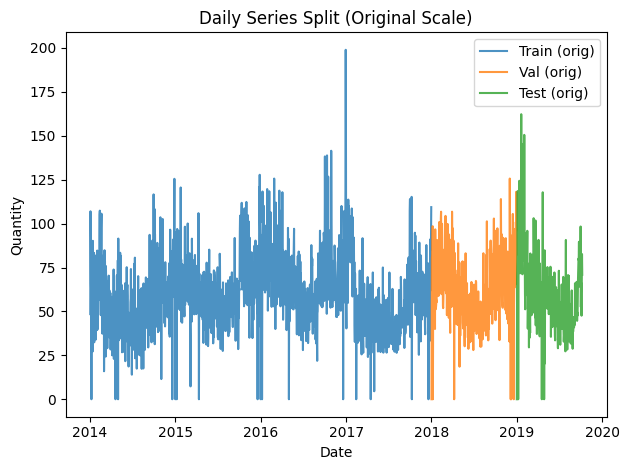

Saved: /home/samanta/Desktop/pharmacy-sales-prediction-lstm-model/results/figures/daily_split_original.png


In [12]:
plt.figure()
plt.plot(daily_train["ds"], daily_train["y"], label="Train (orig)", alpha=0.8)
plt.plot(daily_val["ds"], daily_val["y"], label="Val (orig)", alpha=0.8)
plt.plot(daily_test["ds"], daily_test["y"], label="Test (orig)", alpha=0.8)
plt.title("Daily Series Split (Original Scale)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
out = os.path.join(FIG_DIR, "daily_split_original.png")
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)